# Faire un métamodèle de krigeage


### Définition du modèle

In [1]:
import openturns as ot
import openturns.experimental as otexp
import openturns.viewer as otv

In [2]:
class Plongeoir:
    """
    Définit le modèle physique et probabiliste d'un plongeoir.

    Cette classe encapsule la définition des variables aléatoires d'entrée
    (module de Young, charge, longueur, moment d'inertie) et la fonction
    modèle calculant la déviation verticale de la poutre.

    Examples
    --------
    >>> plongeoir = Plongeoir()
    >>> X = plongeoir.getProbabilisticModel()
    >>> g = plongeoir.getPhysicalModel()
    """
    def __init__(self, avec_dependance=False, rho_LI=-0.2):
        """
        Initialise les distributions et le modèle symbolique.

        Parameters
        ----------
        avec_dependance : bool
            Si True, alors utilise une structure de dépendance avec une 
            copule Gaussienne et un coefficient de corrélation déterminé 
            par rho_LI.
        rho_LI : float
            Le coefficient de corrélation entre L et I
        """
        distributionE = ot.Beta(0.9, 3.5, 65.0e9, 75.0e9)
        distributionE.setDescription(["E (Pa)"])
        parametersF = ot.LogNormalMuSigma(
            300.0, 30.0, 0.0
        )  # Paramétrage par les moments
        distributionF = ot.ParametrizedDistribution(parametersF)
        distributionF.setDescription(["F (N)"])
        distributionL = ot.Uniform(2.50, 2.60)  # En mètres
        distributionL.setDescription(["L (m)"])
        distributionI = ot.Beta(2.5, 4.0, 1.3e-7, 1.7e-7)  # En m⁴
        distributionI.setDescription(["I (m⁴)"])

        if avec_dependance:
            inputDimension = 4  # number of inputs
            R = ot.CorrelationMatrix(inputDimension)
            R[2, 3] = rho_LI
            copula = ot.NormalCopula(ot.NormalCopula.GetCorrelationFromSpearmanCorrelation(R))

            self.distribution = ot.JointDistribution(
                [distributionE, distributionF, distributionL, distributionI], copula
            )
        else:
            self.distribution = ot.JointDistribution(
                [distributionE, distributionF, distributionL, distributionI],
            )

        self.model = ot.SymbolicFunction(["E", "F", "L", "I"], ["F * L ^ 3 / (3 * E * I)"])
        self.model.setInputDescription(self.distribution.getDescription())
        self.model.setOutputDescription(["Y (m)"])

    def getProbabilisticModel(self):
        """
        Retourne la distribution conjointe des variables d'entrée.

        Returns
        -------
        distribution : ot.JointDistribution
            La distribution conjointe des variables aléatoires d'entrée.
        """
        return self.distribution

    def getPhysicalModel(self):
        """
        Retourne le modèle physique sous forme de fonction symbolique.

        Returns
        -------
        model : ot.SymbolicFunction
            La fonction calculant la déviation verticale.
        """
        return self.model

In [3]:
plongeoir = Plongeoir(avec_dependance=True)
inputDistribution = plongeoir.getProbabilisticModel()
model = plongeoir.getPhysicalModel()

### Définition d'un plan d'expériences

Nous considérons un plan d'expériences de type Monte-Carlo simple. Pour cela, on génère un échantillon des entrées grâce à la méthode `getSample`. Puis nous évaluons la sortie en appelant la fonction `model`.

In [4]:
sampleSize_train = 20
X_train = inputDistribution.getSample(sampleSize_train)
yTrain = model(X_train)

Observons la distribution des déviations verticales Y sur la base d'apprentissage. On observe que les déviations plus grandes sont moins fréquentes. 

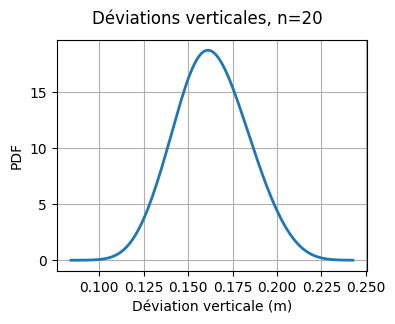

In [5]:
graph = ot.KernelSmoothing().build(yTrain).drawPDF()
graph.setXTitle("Déviation verticale (m)")
graph.setTitle(f"Déviations verticales, n={yTrain.getSize()}")
graph.setLegends([""])
_ = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})

### Création du méta-modèle

Pour créer le krigeage, on choisit une tendance constante avec la classe `ConstantBasisFactory`. Puis on utilise un modèle de covariance de type exponentielle carrée. Enfin, on utilise la classe `GaussianProcessFitter` pour créer le krigeage en utilisant la base d'apprentissage, le modèle de covariance et la tendance.

In [6]:
dimension = inputDistribution.getDimension()
basis = ot.ConstantBasisFactory(dimension).build()
covarianceModel = ot.SquaredExponential([1.0] * dimension, [1.0])
covarianceModel.setScale(X_train.getMax())
fitter = otexp.GaussianProcessFitter(X_train, yTrain, covarianceModel, basis)
scaleOptimizationBounds = ot.Interval(X_train.getMin(), X_train.getMax())
fitter.setOptimizationBounds(scaleOptimizationBounds)
fitter.run()
gpr = otexp.GaussianProcessRegression(fitter.getResult())
gpr.run()
gprTesult = gpr.getResult()
krigingMetaModel = gprTesult.getMetaModel()

La méthode `run` a évalué les paramètres du modèle par la méthode du maximum de vraisemblance. 

On peut alors afficher la tendance constante du modèle.

In [7]:
gprTesult.getTrendCoefficients()

class=Point name=Unnamed dimension=1 values=[0.42349]

On peut également afficher les paramètres du modèle de covariance, estimés par la méthode du maximum de vraisemblance.

In [8]:
gprTesult.getCovarianceModel()

class=SquaredExponential scale=class=Point name=Unnamed dimension=4 values=[7.20029e+10,363.287,2.50948,1.59996e-07] amplitude=class=Point name=Unnamed dimension=1 values=[0.367956]

On souhaite ensuite valider le métamodèle de krigeage. Pour cela, on génère un échantillon de validation de taille 100 et on évalue la sortie du modèle sur cet échantillon.

In [9]:
sampleSizeTest = 100
xTest = inputDistribution.getSample(sampleSizeTest)
yTest = model(xTest)

Sur l'échantillon de validation, on évalue les sorties du méta-modèle.

In [10]:
yTest_MM = krigingMetaModel(xTest)

La classe `MetaModelValidation` facilite le travail de validation d'un métamodèle. 


Si on utilise l'échantillon d'apprentissage pour estimer le score R², celui-ci est égal à 1. La raison est que le métamodèle de krigeage est interpolant.

In [11]:
r2Score = ot.MetaModelValidation(yTrain, krigingMetaModel(X_train)).computeR2Score()[0]
print(f"R² = {r2Score}")

R² = 1.0



Pour réaliser la validation, on utilise les entrées de la base de validation, les sorties correspondantes et le métamodèle.

In [12]:
validation = ot.MetaModelValidation(yTest, krigingMetaModel(xTest))

La méthode `computeR2Score` permet d'estimer le coefficient $Q^2$.

In [13]:
validation.computeR2Score()[0]

0.9999676535647316

Puisque le $Q^2$ est supérieur à 0.95, on peut dire que c'est un très bon méta-modèle.

Il est intéressant de dessiner l'histogramme des résidus : on peut le faire avec la classe `HistogramFactory` appliquée à l'échantillon des résidus `r`. 

On observe que les résidus négatifs sont presque aussi fréquents que les résidus positifs : c'est plutôt un signe positif pour la qualité du métamodèle. Dans notre cas, la déviation verticale est plutôt petite, de l'ordre de $10^{-5}$. Cela implique qu'il n'est pas si simple de voir si, en valeur absolue, les résidus sont plutôt petits, ou non : le graphique que nous dessinerons par la suite est plus fiable de ce point de vue.

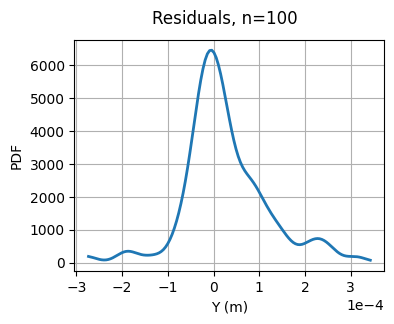

In [14]:
residualsSample = validation.getResidualSample()
graph = ot.KernelSmoothing().build(residualsSample).drawPDF()
graph.setTitle(f"Residuals, n={residualsSample.getSize()}")
graph.setLegends([""])
_ = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})

La méthode `drawValidation` permet de comparer les données observées et les prédictions du méta-modèle. 

On observe que les croix rouges sont à proximité de la première bissectrice : cela montre que le méta-modèle est plutôt de bonne qualité. Toutefois, pour les grandes déviations, les points rouges sont plus éloignées de la première bissectrice : le métamodèle est moins bon pour les grandes déviations.

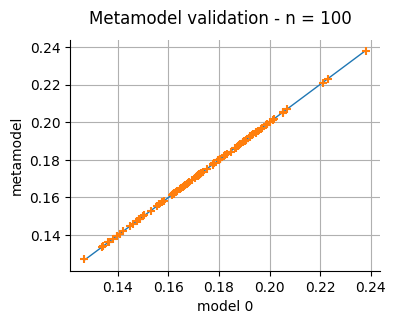

In [15]:
graph = validation.drawValidation()
_ = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})

### Solution de l'exercice 1 : sensibilité à la taille de l'échantillon d'apprentissage

In [16]:
sampleSize_train = 100
X_train = inputDistribution.getSample(sampleSize_train)
yTrain = model(X_train)

dimension = inputDistribution.getDimension()
basis = ot.ConstantBasisFactory(dimension).build()
covarianceModel = ot.SquaredExponential([1.0] * dimension, [1.0])
covarianceModel.setScale(X_train.getMax())
fitter = otexp.GaussianProcessFitter(X_train, yTrain, covarianceModel, basis)
fitter.setOptimizationBounds(scaleOptimizationBounds)
fitter.run()
gpr = otexp.GaussianProcessRegression(fitter.getResult())
gpr.run()
gprTesult = gpr.getResult()
krigingMetaModel = gprTesult.getMetaModel()

In [17]:
sampleSizeTest = 100
xTest = inputDistribution.getSample(sampleSizeTest)
yTest = model(xTest)

validation = ot.MetaModelValidation(yTest, krigingMetaModel(xTest))
validation.computeR2Score()[0]

0.9999999934485423

On observe que le coefficient de prédictivité est excellent : le métamodèle avec 100 points est de très bonne qualité.

### Solution de l'exercice 2 : utilisation d'une tendance

In [18]:
sampleSize_train = 20
X_train = inputDistribution.getSample(sampleSize_train)
yTrain = model(X_train)

dimension = inputDistribution.getDimension()
basis = ot.LinearBasisFactory(dimension).build()  # <- Tendance linéaire
covarianceModel = ot.SquaredExponential([1.0] * dimension, [1.0])
covarianceModel.setScale(X_train.getMax())
fitter = otexp.GaussianProcessFitter(X_train, yTrain, covarianceModel, basis)
fitter.setOptimizationBounds(scaleOptimizationBounds)
fitter.run()
gpr = otexp.GaussianProcessRegression(fitter.getResult())
gpr.run()
gprTesult = gpr.getResult()
krigingMetaModel = gprTesult.getMetaModel()

In [19]:
trendCoefficients = gprTesult.getTrendCoefficients()
print(f"Beta_0 = {trendCoefficients[0]}")
print(f"Beta_E = {trendCoefficients[1]}")
print(f"Beta_F = {trendCoefficients[2]}")
print(f"Beta_L = {trendCoefficients[3]}")
print(f"Beta_I = {trendCoefficients[4]}")
sampleSizeTest = 100
xTest = inputDistribution.getSample(sampleSizeTest)
yTest = model(xTest)
validation = ot.MetaModelValidation(yTest, krigingMetaModel(xTest))
q2Score = validation.computeR2Score()[0]
print(f"Q² = {q2Score}")

Beta_0 = 1.7909826059073917e-23
Beta_E = 1.906721554139388e-12
Beta_F = 5.7268110244465015e-21
Beta_L = 4.5091814366326393e-23
Beta_I = 2.440213807312901e-30
Q² = 0.9999319208116534


On observe que les paramètres de la tendance sont proches de zéro. De plus le score Q² est toujours aussi satisfaisant. Cela montre que prendre en compte une tendance linéaire ne permet pas d'améliorer la qualité des prédictions dans ce cas.

### Solution de l'exercice 3 : nombre d'observations et nombre de paramètres

Comptons le nombre de paramètres estimés.

In [20]:
listOfPoints = gprTesult.getTrendCoefficients()  # One trend for each output
numberOfTrendParameters = listOfPoints.getDimension()
numberOfTrendParameters

5

In [21]:
estimatedCovarianceModel = gprTesult.getCovarianceModel()
indices = estimatedCovarianceModel.getActiveParameter()
numberOfCovarianceParameters = indices.getSize()
numberOfCovarianceParameters

5

In [22]:
numberOfParameters = numberOfTrendParameters + numberOfCovarianceParameters
numberOfParameters

10

In [23]:
trainingSampleSize = X_train.getSize()
trainingSampleSize

20

On calcule le ratio entre le nombre d'observations et le nombre de paramètres. 

In [24]:
learningRatio = trainingSampleSize / numberOfParameters
learningRatio

2.0

Si le nombre d'observations est très supérieur au nombre de paramètres, alors l'apprentissage est de qualité. Avec environ 2 observations par paramètres, le nombre d'observations est suffisant, mais il pourrait être plus grand pour assurer une meilleure qualité. 

### Solution de l'exercice 4 : distribution des résidus

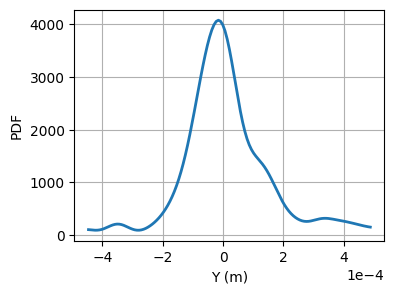

In [25]:
validation = ot.MetaModelValidation(yTest, krigingMetaModel(xTest))
hist = validation.getResidualDistribution()
graph = hist.drawPDF()
graph.setLegends([""])
_ = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})

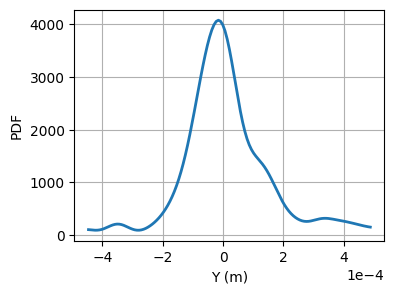

In [26]:
residualsSample = validation.getResidualSample()
graph = ot.KernelSmoothing().build(residualsSample).drawPDF()
graph.setLegends([""])
_ = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})

On observe que les deux graphiques sont identiques : les deux méthodes sont strictement équivalentes.

### Solution de l'exercice 5 : utiliser un algorithme d'optimisation global

In [27]:
def createUniformJointDistributionFromInterval(interval):
    """
    Crée une loi multidimensionnelle uniforme à partir d'un intervalle.

    Chaque composante marginale est une loi uniforme indépendante.

    Voir https://github.com/openturns/openturns/issues/3112.

    Parameters
    ----------
    interval : ot.Interval
        L'intervalle. La borne inférieure de chaque composante doit être
        inférieure ou égale à la borne supérieure.

    Returns
    -------
    distribution : ot.JointDistribution
        La loi jointe.
    """
    lowerBound = interval.getLowerBound()
    upperBound = interval.getUpperBound()
    dimension = interval.getDimension()
    marginalDistributions = []
    for i in range(dimension):
        uniformMarginal = ot.Uniform(lowerBound[i], upperBound[i])
        marginalDistributions.append(uniformMarginal)
    jointDistribution = ot.JointDistribution(marginalDistributions)
    return jointDistribution

# Create constant basis
dimension = inputDistribution.getDimension()
basis = ot.ConstantBasisFactory(dimension).build()
# Create squared exponential model
covarianceModel = ot.SquaredExponential([1.0] * dimension, [1.0])
covarianceModel.setScale(X_train.getMax())
# Create the fitter
fitter = otexp.GaussianProcessFitter(X_train, yTrain, covarianceModel, basis)
# Tune the optimization bounds
scaleOptimizationBounds = ot.Interval(X_train.getMin(), X_train.getMax())
fitter.setOptimizationBounds(scaleOptimizationBounds)
# Tune the optimization algorithme: configure MultiStart
solver = fitter.getOptimizationAlgorithm()
sampleSizeMultiStart = 25  # Number of restarts
scaleDistribution = createUniformJointDistributionFromInterval(scaleOptimizationBounds)
starting_points = scaleDistribution.getSample(sampleSizeMultiStart)
multiStartSolver = ot.MultiStart(solver, starting_points)
fitter.setOptimizationAlgorithm(multiStartSolver)
fitter.run()
gpr = otexp.GaussianProcessRegression(fitter.getResult())
gpr.run()
gprTesult = gpr.getResult()
gprTesult.getCovarianceModel()


class=SquaredExponential scale=class=Point name=Unnamed dimension=4 values=[6.50186e+10,360.413,2.50588,1.57612e-07] amplitude=class=Point name=Unnamed dimension=1 values=[0.396489]

On constate que l'optimisation fonctionne correctement. Pour le vérifier, on pourrait valider le métamodèle. 

### Solution de l'exercice 6 : Utiliser un plan lhsExperiment optimisé

Avant d'utiliser un plan d'expérience `LHSExperiment`, nous allons utiliser la fonction `DrawPairs` pour visualiser un échantillon Monte-Carlo simple.

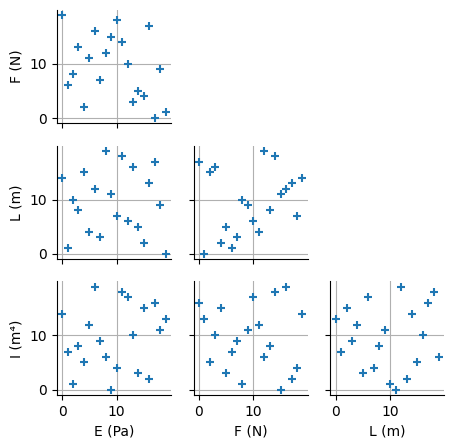

In [28]:
sampleSize = 20
inputTrain = inputDistribution.getSample(sampleSize)
clouds = ot.VisualTest.DrawPairs(inputTrain.rank())
_ = otv.View(clouds, figure_kw={"figsize": (5.0, 5.0)})

On observe qu'il y a des amas et des trous dans certaines projections bidimensionnelles. Un plan lhsExperiment peut aider à éviter cela.

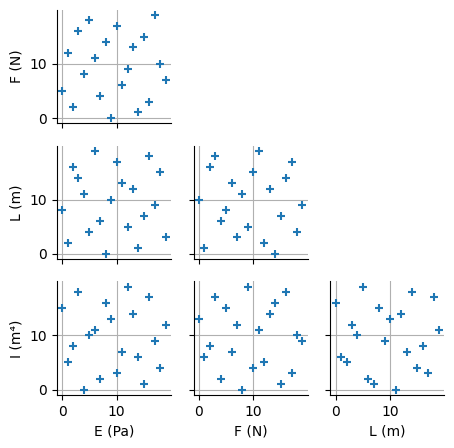

In [29]:
def buildCantileverKrigingMetamodel(
    model,
    inputTrain,
    basis,
    covarianceModel,
    minScaleFactor=0.1,
    maxScaleFactor=5.0,
):
    """Construit un métamodèle par krigeage pour une poutre encastrée.

    Cette fonction calibre un modèle de processus gaussien en utilisant des données
    d'entraînement, une base de fonctions et un modèle de covariance. Elle ajuste
    les paramètres de corrélation par optimisation avant d'extraire le métamodèle
    final pour effectuer des prédictions rapides.

    Parameters
    ----------
    model : openturns.Function
        Le modèle numérique original (modèle "lourd") à approximer.
    inputTrain : openturns.Sample
        L'échantillon des variables d'entrée utilisé pour l'apprentissage.
    basis : openturns.Basis
        La base de fonctions utilisée pour la partie tendance du krigeage.
    covarianceModel : openturns.CovarianceModel
        Le modèle de covariance définissant la structure de corrélation spatiale.

    Returns
    -------
    krigingMetaModel : openturns.Function
        Le métamodèle (réponse analytique approximée) issu du processus gaussien.

    Examples
    --------
    >>> import openturns as ot
    >>> import openturns.experimental as otexp
    >>> # Configuration type pour une poutre console
    >>> krig_mm = buildCantileverKrigingMetamodel(my_model, X_train, my_basis, my_cov)
    """
    covarianceModel.setScale(inputTrain.getMax())
    yTrain = model(inputTrain)
    fitter = otexp.GaussianProcessFitter(inputTrain, yTrain, covarianceModel, basis)
    # Calcul de l'étendue pour définir les bornes d'optimisation (longueurs de corrélation)
    plageEntree = inputTrain.getMax() - inputTrain.getMin()
    scaleOptimizationBounds = ot.Interval(
        minScaleFactor * plageEntree, maxScaleFactor * plageEntree
    )
    fitter.setOptimizationBounds(scaleOptimizationBounds)
    fitter.run()
    gpr = otexp.GaussianProcessRegression(fitter.getResult())
    gpr.run()
    gprResult = gpr.getResult()
    krigingMetaModel = gprResult.getMetaModel()
    return krigingMetaModel


dimension = inputDistribution.getDimension()
basis = ot.ConstantBasisFactory(dimension).build()
covarianceModel = ot.SquaredExponential([1.0] * dimension, [1.0])

sampleSize = 20
inputDimension = inputDistribution.getDimension()
lhsExperiment = ot.LHSExperiment(inputDistribution, sampleSize)
lhsExperiment.setAlwaysShuffle(True)
saProfile = ot.GeometricProfile(10.0, 0.95, 20000)
criterion = ot.SpaceFillingC2()
lhsOptimizationAlgo = ot.SimulatedAnnealingLHS(lhsExperiment, criterion, saProfile)
lhsOptimizationAlgo.generate()
lhsDesign = lhsOptimizationAlgo.getResult()
inputTrain = lhsDesign.getOptimalDesign()
inputTrain.setDescription(inputDistribution.getDescription())
clouds = ot.VisualTest.DrawPairs(inputTrain.rank())
_ = otv.View(clouds, figure_kw={"figsize": (5.0, 5.0)})

On observe que les trous est les amas sont moins grossiers qu'ils ne l'étaient dans le plan Monte-Carlo simple.

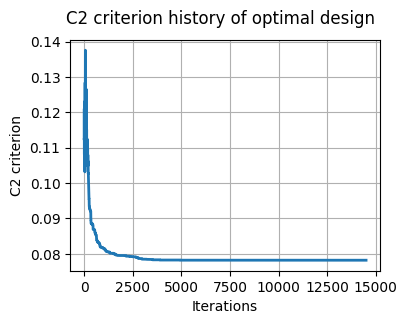

In [30]:
graph = lhsDesign.drawHistoryCriterion()
_ = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})

In [31]:
krigingMetamodel = buildCantileverKrigingMetamodel(
    model, inputTrain, basis, covarianceModel
)
sampleSizeTest = 100
xTest = inputDistribution.getSample(sampleSizeTest)
yTest = model(xTest)
validation = ot.MetaModelValidation(yTest, krigingMetaModel(xTest))
validation.computeR2Score()[0]
#

0.9999582581022052

Pour vérifier l'utilité du carré latin, on pourrait réaliser une expérience permettant d'observer le score Q² en fonction de la taille du plan d'expérience. Pour chaque taille de plan d'expériences, on génère un carré latin et on évalue le score Q². Par comparaison, on peut utiliser un plan Monte-Carlo simple. On peut alors comparer les scores Q² issus des plans Monte-Carlo et carré latin.

### Solution de l'exercice 7 : Simulation de trajectoires conditionnelles

In [32]:
numberOfEvaluationPoints = 5
input_sample = inputDistribution.getSample(numberOfEvaluationPoints)
simplices = [list(range(numberOfEvaluationPoints))]
mesh = ot.Mesh(input_sample, simplices)
print(mesh)
print(mesh.getVertices())
conditionedGP = otexp.ConditionedGaussianProcess(gprTesult, mesh)
conditionedGP.getSample(3)

Mesh(dimension=4, vertices=5, simplices=1)
    [ E (Pa)        F (N)         L (m)         I (m⁴)      ]
0 : [   6.74692e+10 292.777         2.57189       1.35983e-07 ]
1 : [   6.63859e+10 270.058         2.5195        1.47954e-07 ]
2 : [   6.86429e+10 369.905         2.52985       1.43591e-07 ]
3 : [   6.52453e+10 278.516         2.53197       1.34533e-07 ]
4 : [   6.61196e+10 289.617         2.50417       1.63054e-07 ]


class=ProcessSampleImplementation mesh=class=Mesh name=Unnamed dimension=4 vertices=class=Sample name=JointDistribution implementation=class=SampleImplementation name=JointDistribution size=5 dimension=4 description=[E (Pa),F (N),L (m),I (m⁴)] data=[[6.74692e+10,292.777,2.57189,1.35983e-07],[6.63859e+10,270.058,2.5195,1.47954e-07],[6.86429e+10,369.905,2.52985,1.43591e-07],[6.52453e+10,278.516,2.53197,1.34533e-07],[6.61196e+10,289.617,2.50417,1.63054e-07]] simplices=[[0,1,2,3,4]] values=[class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=5 dimension=1 description=[y0] data=[[0.181146],[0.146538],[0.20166],[0.171461],[0.14138]],class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=5 dimension=1 description=[y0] data=[[0.180947],[0.146576],[0.201319],[0.171566],[0.141297]],class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=5 dimension=1 description=[y0] data=[[0.181001],[0.146571],[0.201393],[0.171517],[0.141184]]]

Le processsu obtenu peut être utilisé pour simuler un grand nombre de trajectoires possibles, par exemple.